# Expériences sur données réelles

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from datetime import datetime, timedelta

from src.poisson_process import NHPoissonProcess
from src.mcmc import PoissonMCMC
from src.visualisation import *
from parameters.params import Params
from src.densities import return_level
from src.rhat_infinity import *

COLOR_LIST = ["xkcd:cobalt", 
              "xkcd:turtle green", 
              "xkcd:berry", 
              "xkcd:tangerine", 
              "xkcd:pastel blue"]

## Débits du Rhône 

Voir section 4.2.1 de la thèse de Clément

**Seuil recommendé par EDF**: 2400


In [2]:
data_file = "data/Golfech_CRUE_1915-2013.txt"



def extract_data_castor(threshold):
    
    observations_under_u = []
    observations_above_u = []

    time_under_u = []
    time_over_u = []
    

    with open(data_file, "r", encoding="ISO-8859-1") as f:
        #skipping the first information lines
        for i in range(7):
            f.readline()

        current_line = f.readline().split()
        current_time = datetime.strptime(current_line[0][1:-1], '%d/%m/%Y')
        while current_line:
            current_time = datetime.strptime(current_line[0][1:-1], '%d/%m/%Y')
            if current_time.month == 12 or current_time.month < 6:
                if float(current_line[1]) > threshold:
                    observations_above_u.append(float(current_line[1]))
                    time_over_u.append(current_time)
                elif float(current_line[1]) > 0:
                    observations_under_u.append(float(current_line[1]))
                    time_under_u.append(current_time)
            current_line = f.readline().split()
        f.close()
    
    return observations_under_u, observations_above_u, time_under_u, time_over_u


def decluster_data(obs, time, cluster_int = 3):
    obs_res, time_res = [], []
    
    idx = 0
    while idx < len(obs)-1: 
        
        current_obs = obs[idx]
        current_time = time[idx]
        while idx < len(obs)-1 and abs(time[idx] - time[idx+1]).days <= cluster_int:
            idx += 1
            current_obs = max(current_obs, obs[idx])
#             current_time = max(current_time, time[idx])
        obs_res.append(current_obs) 
        time_res.append(current_time)
        idx += 1
    return obs_res, time_res


# Threshold Selection

In [3]:
# decluster = False

# u_list = np.arange(1000, 5000, 10)
# k_list = []
# hill_estimators = []
# mean_residuals = []

# for u in u_list:

#     _, obs, _, time = extract_data_castor(threshold = u)

#     if decluster:
#         obs, _ = decluster_data(obs, time)
    
#     k = len(obs)
#     k_list.append(k)
    
#     hill_estimators.append(np.mean(np.log(obs)) - np.log(min(obs)))
#     mean_residuals.append(np.mean(obs) - u)

### Hill Plot

In [4]:
# fig = plt.figure(figsize=(18,12))
# ax1 = fig.add_subplot(111)
# plt.plot(k_list, hill_estimators, "+", color=COLOR_LIST[0], ms = 10)


# # ax2 = ax1.twiny()
# # ax2.set_xbound(5000, 1000)
# ax1.set_xlabel("Number of Excesses", fontsize = 15)
# # ax2.set_xlabel("Threshold", fontsize = 15)
# plt.show()

### Mean Residual life plot

In [5]:
# fig = plt.figure(figsize=(18,12))
# ax1 = fig.add_subplot(111)
# plt.plot(u_list, mean_residuals, "+", color=COLOR_LIST[0], ms = 10)

# ax1.set_xlabel("Threshold", fontsize = 15)
# plt.show()

In [6]:
threshold = 2000
decluster = True
n_years = 99

observations_under_u, obs, time_under_u, time = extract_data_castor(threshold = threshold)

if decluster:
    obs, time = decluster_data(obs, time)

n_obs = len(obs)
n_total = len(observations_under_u)+n_obs

print("Total number of observations: {}".format(n_total))
print("Number of observations above u : {}".format(n_obs))
print("Max value : {}".format(max(obs)))

Total number of observations: 17805
Number of observations above u : 182
Max value : 7550.0


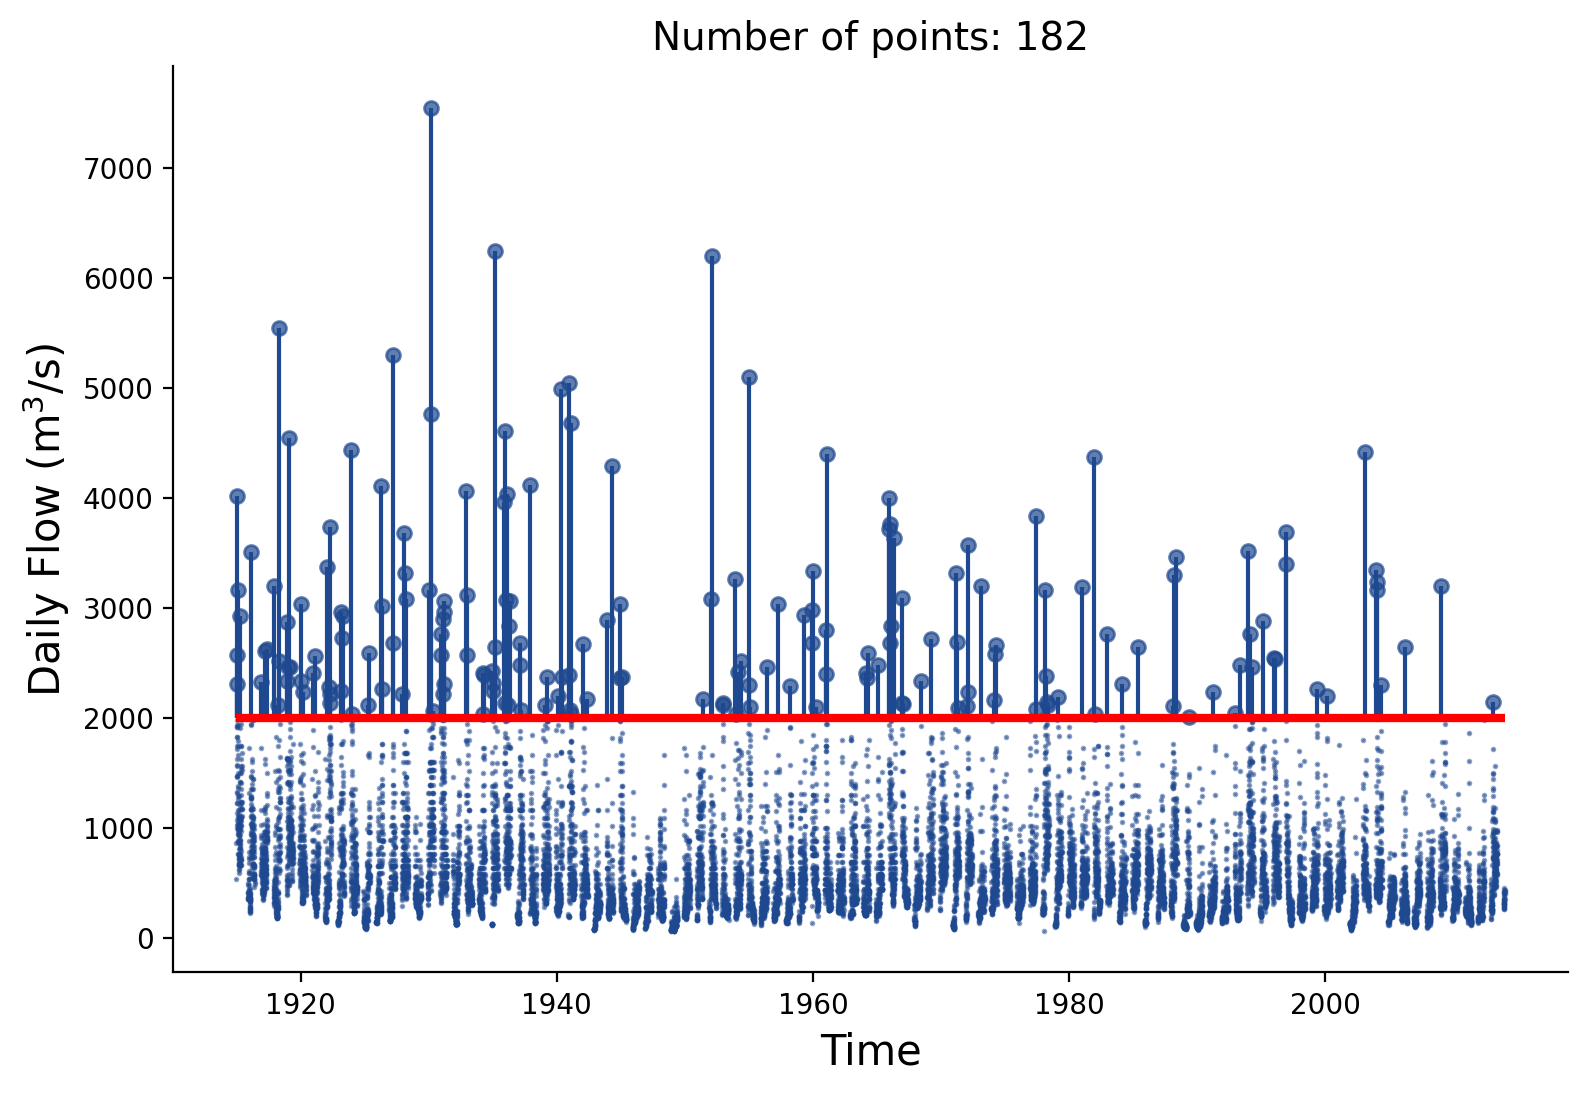

In [8]:
time_scale = range(len(observations_under_u)+n_obs)

fig = plt.figure(figsize=(9, 6), dpi=200)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(time_under_u, observations_under_u, '.', color=COLOR_LIST[0], alpha=0.5, ms=2)
ax.vlines(time, [threshold], obs, colors=COLOR_LIST[0])

ax.plot(time, obs, ".", alpha = 0.7, linewidth=1.5, ms = 10, color=COLOR_LIST[0])

ax.hlines(threshold, min(time + time_under_u), max(time + time_under_u), colors="r", linewidths=3)
# ax.vlines(min(time + time_under_u), threshold / max(obs), 1, transform=ax.get_xaxis_transform(), colors="r")
# ax.vlines(max(time + time_under_u), threshold / max(obs), 1, transform=ax.get_xaxis_transform(), colors="r")

ax.set_ylabel("Daily Flow (m$^3$/s)", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)

ax.set_title("Number of points: " + str(n_obs), fontsize=14)
plt.show()

### MCMC


Config file:  Config7
Orthogonal param.

Config file:  Config8
Orthogonal param.

Config file:  Config9
Orthogonal param.

Config file:  Config10
Orthogonal param.

Config file:  Config11
Orthogonal param.


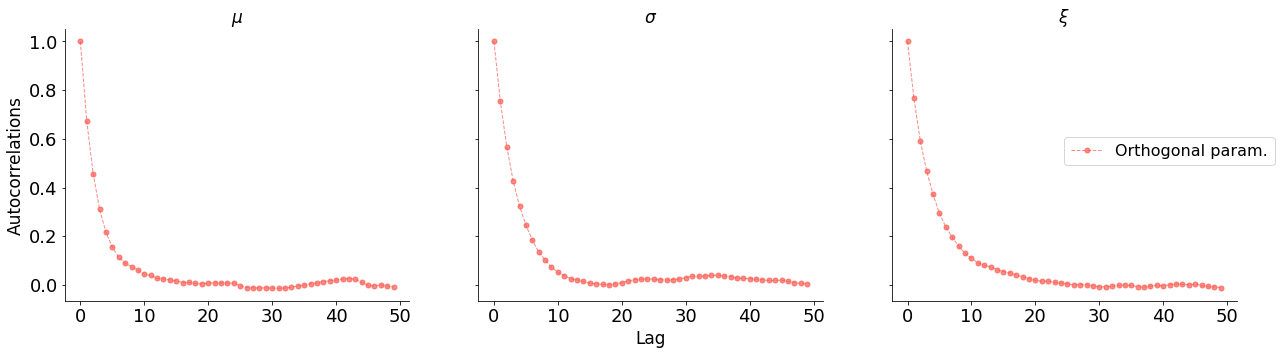

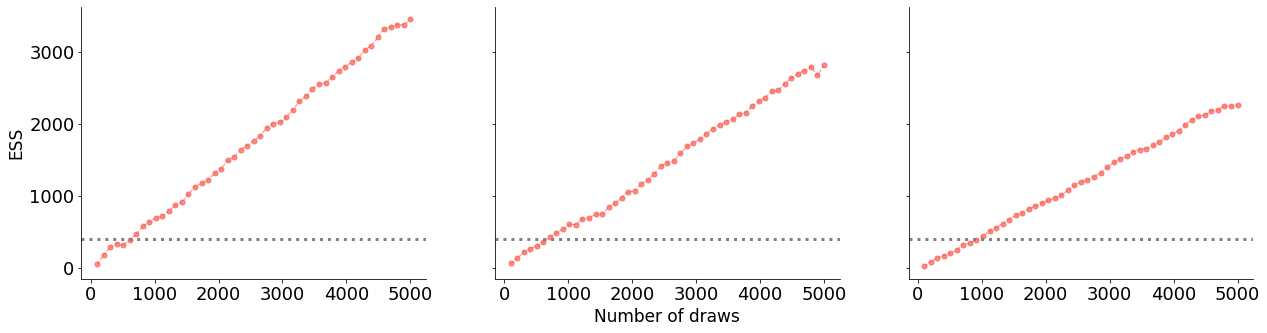

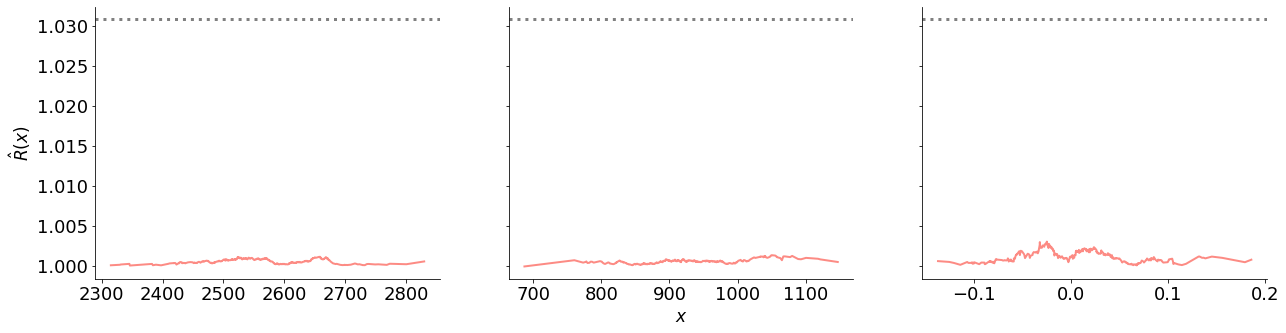

In [8]:
r_list = np.logspace(0.1, 4, 200)


mcmc_params_directory = "parameters/mcmc/"
poisson_params_directory = "parameters/poisson_simu/"

mcmc_configs = ["Config7", "Config8", "Config9", "Config10", "Config11"]
# mcmc_configs = ["Config7", "Config8"]

traces = []
names = []

for filename in mcmc_configs:
    print("\nConfig file: ", filename)
    mcmc_params = Params(mcmc_params_directory + filename + ".json")
    print(mcmc_params.name)

    nb_dim = len(mcmc_params.priors)
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"]]

    if nb_dim == 3:
        priors.append(mcmc_params.priors["p3"])

        if mcmc_params.init_p1_by_u:
            init_val = n_obs if mcmc_params.orthogonal_param else threshold
            priors[2] = priors[2].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=threshold, m=n_years, period_range=r_list,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
#     print("Choice of m = {} for MCMC".format(MCMC.m))

    trace = MCMC.run(verbose=False)

    names.append(mcmc_params.name)
    traces.append(trace)

var_names = ["mu_m", "sig_m", "xi"]            
plot_autocorr(traces =[traces[1]], labels = [names[1]], var_names = var_names)
plot_ess(traces = [traces[1]], labels = [names[1]], var_names = var_names)
plot_r_hat_x(traces = [traces[1]], labels = [names[1]], var_names = var_names)

In [9]:
# az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"]).to_latex(index=True)


 Summary:


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mode
mu_m,2562.896,82.292,2405.653,2726.012,1.400,0.991,3471.0,4797.0,1.0,2545.772
sig_m,919.380,71.464,787.929,1068.748,1.347,0.952,2792.0,3223.0,1.0,847.961
xi,0.005,0.055,-0.106,0.111,0.001,0.001,2220.0,2516.0,1.0,-0.008


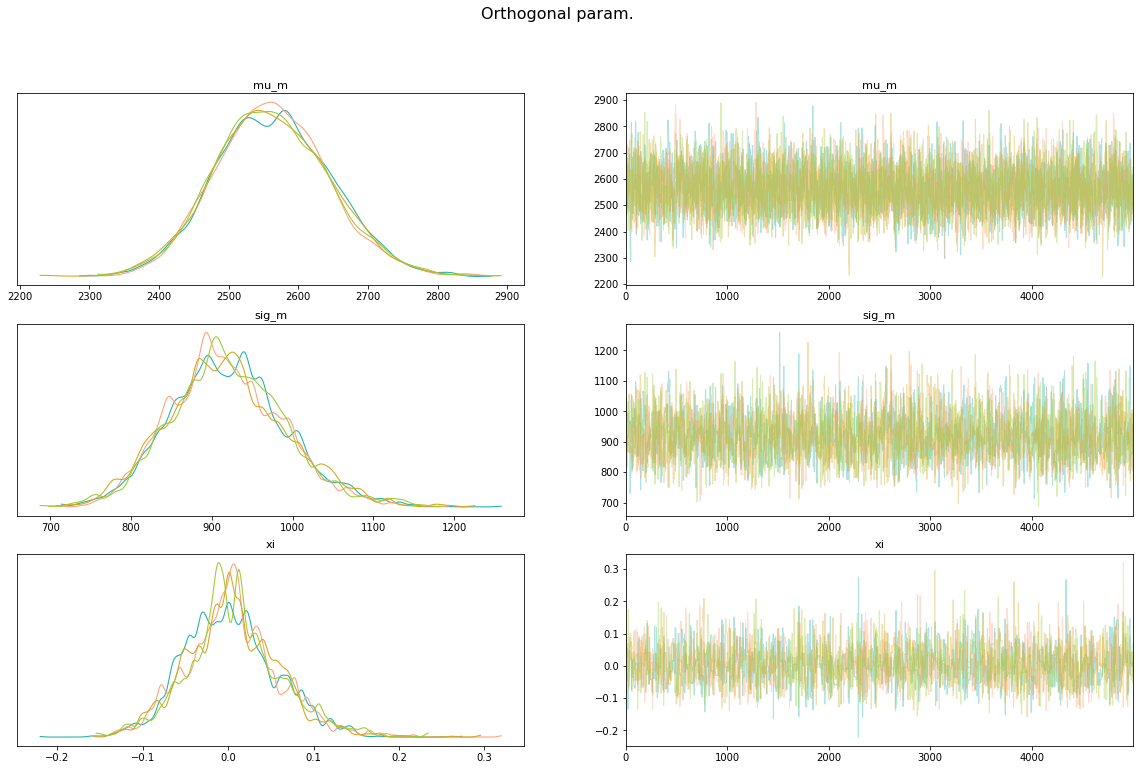

In [10]:
func_dict = {"mode": lambda x: scipy.stats.mode(x, axis=None).mode[0]}

print("\n Summary:")
display(az.summary(data=traces[1], stat_funcs=func_dict, 
                   var_names=["mu_m", "sig_m", "xi"], hdi_prob = 0.95))
plot_trace(traces[1], var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name)
plt.show()



### Niveau de retour

In [11]:
def extract_annual_maxima():
    _, obs, _, time = extract_data_castor(threshold = 1)
        
    res = []
    idx = 0
    
    while idx < len(obs)-1:
        current_max = obs[idx]
        idx += 1
        while idx < len(obs) and time[idx].year == time[idx-1].year:
            current_max = max(current_max, obs[idx])
            idx += 1
        res.append(current_max)
    
    if idx < len(obs) and time[idx].year != time[idx-1].year:
        res.append(obs[idx])
    
    return res


In [12]:
from matplotlib.ticker import NullFormatter


def return_level(mu,sig,xi,yp):
    # yp = -np.log(1-1/r)
    return mu - sig/xi * (1 - yp**(-xi))

def return_level_0(mu,sig,xi,yp):
    # yp = -np.log(1-1/r)
    return mu - sig * np.log(yp)


def get_return_level(r, trace, param, light_tail=False):
    y = -np.log(1-1/r)
    
    level_function = return_level_0 if light_tail else return_level
    
    return level_function(param["mu_m"], param["sig_m"], param["xi"], y) 



def plot_return_level(trace, r_list, method = "l2", n_data_plotted = 60, light_tail=False, ylabel=True):
        
    if method == "l1":
        param = az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                                var_names=["mu_m", "sig_m", "xi"])["mean"]
        levels_mean = [get_return_level(r, trace, param, light_tail) for r in r_list]

        param = az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                                var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
        levels_hdi1 = [get_return_level(r, trace, param, light_tail) for r in r_list]

        param = az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                                var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]
        levels_hdi2 = [get_return_level(r, trace, param, light_tail) for r in r_list]

        
    elif method == "l2":
        levels_mean = np.asarray(az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                                            var_names=["q"])["mean"])

        levels_hdi1 = np.asarray(az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                                            var_names=["q"])["hdi_2.5%"])

        levels_hdi2 = np.asarray(az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                                            var_names=["q"])["hdi_97.5%"])

    fig = plt.figure(figsize=(9,6), dpi = 300)
    ax = fig.add_subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(2e3, 2e4)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

    
    plt.plot(r_list, levels_mean, "-", color=COLOR_LIST[1], linewidth = 2)
    plt.plot(r_list, levels_hdi1, "--", color=COLOR_LIST[0], linewidth = 3)
    plt.plot(r_list, levels_hdi2, "--", color=COLOR_LIST[0], linewidth = 3)
    
#     plt.plot(r_list, levels_mean_j, "-", color=COLOR_LIST[2], linewidth = 2)


    annual_max = np.sort(extract_annual_maxima())[::-1]

    empirical_r = [(n_years)/(i+1) for i in range(n_data_plotted)]
    
    plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)
    plt.plot(empirical_r, annual_max[:n_data_plotted], ".", color="black", ms=15)
    plt.xlabel("Return Period (years)",  fontsize = 17)
    plt.ylabel("Return Level (m$^3$/s)",  fontsize = 17)

    if ylabel:
        plt.legend(["Post. mean", "95%-CI"], fontsize = 17)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())

    

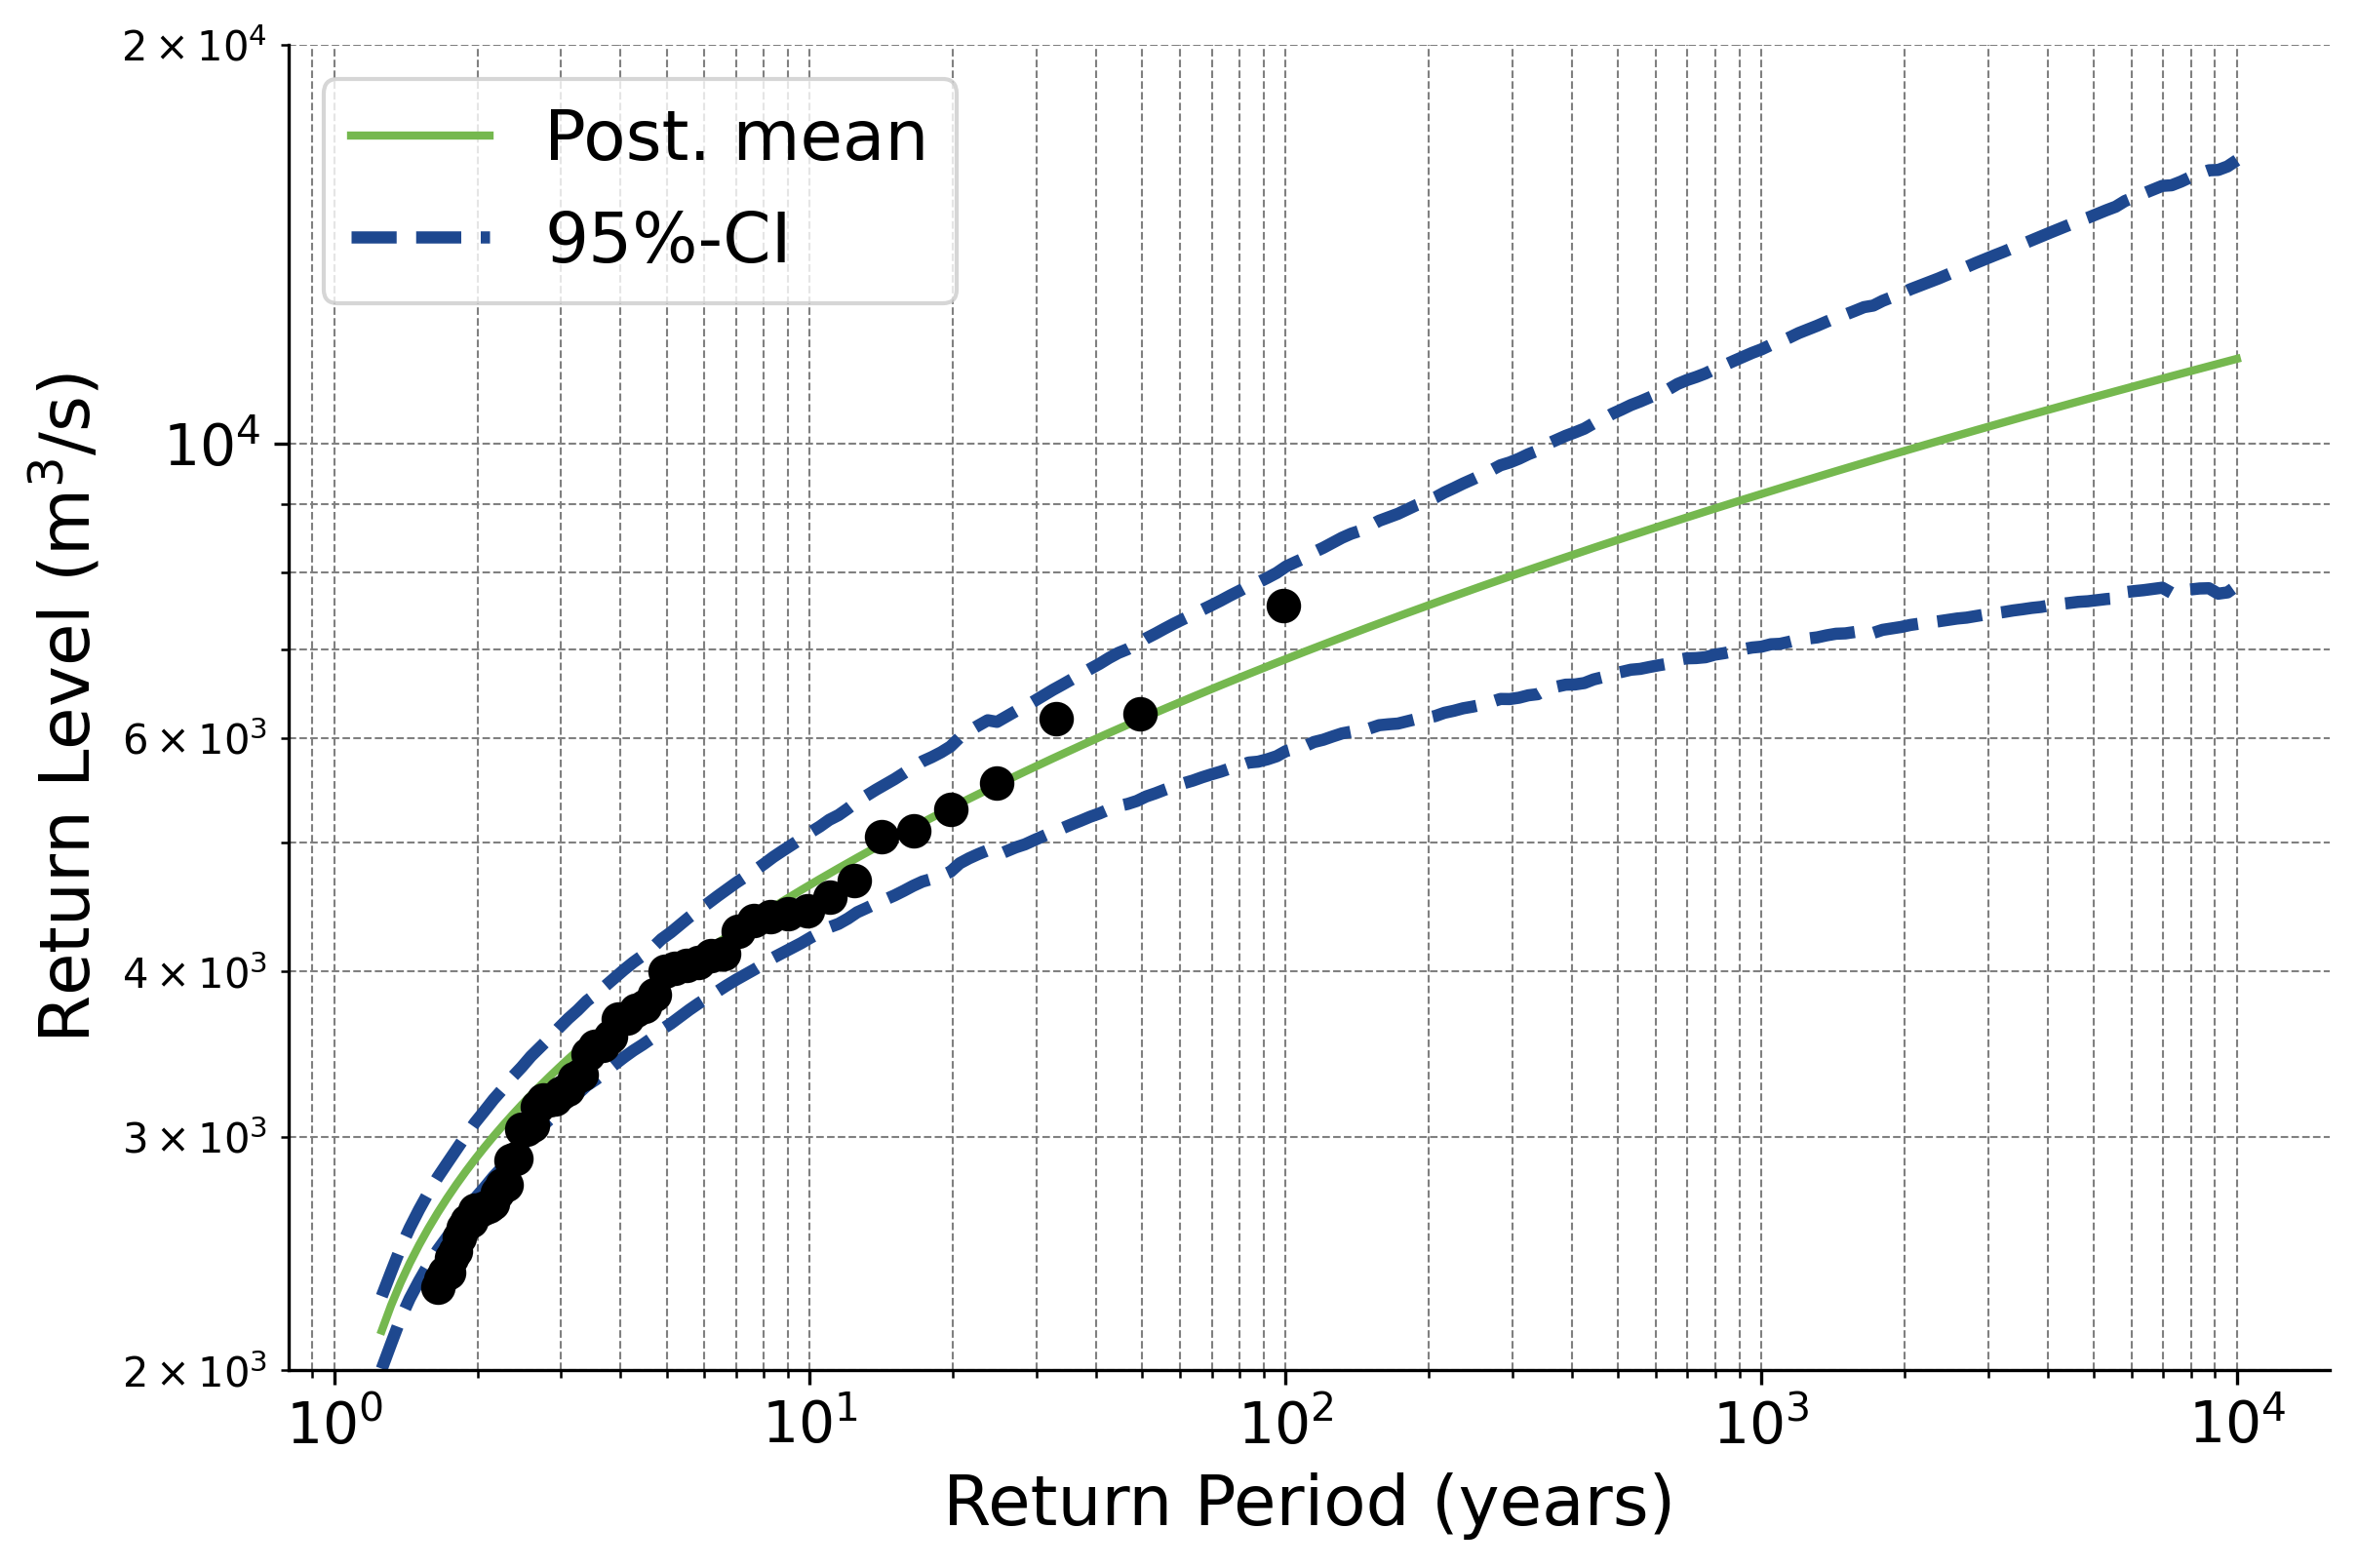

In [13]:
plot_return_level(traces[1], r_list)
plt.show()

In [33]:
param_mean = az.summary(data=traces[0], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["mu_m", "sig_m", "xi"])["mean"]
param_hdi1 = az.summary(data=traces[0], stat_funcs=func_dict, hdi_prob = 0.95,
                    var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
param_hdi2 = az.summary(data=traces[0], stat_funcs=func_dict, hdi_prob = 0.95,
                var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]

print("Méthode 1:")
print(get_return_level(r = 1000, trace = traces[0], param = param_hdi1))
print(get_return_level(r = 1000, trace = traces[0], param = param_mean))
print(get_return_level(r = 1000, trace = traces[0], param = param_hdi2))
print("")

print("Méthode 2:")
print(az.summary(data=traces[0], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["hdi_2.5%"][148])
print(az.summary(data=traces[0], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["mean"][148])
print(az.summary(data=traces[0], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["hdi_97.5%"][148])

Méthode 1:
5940.964612227868
9269.090105957273
16551.88504149722

Méthode 2:
6746.321
9593.164
13563.932


## PC Prior

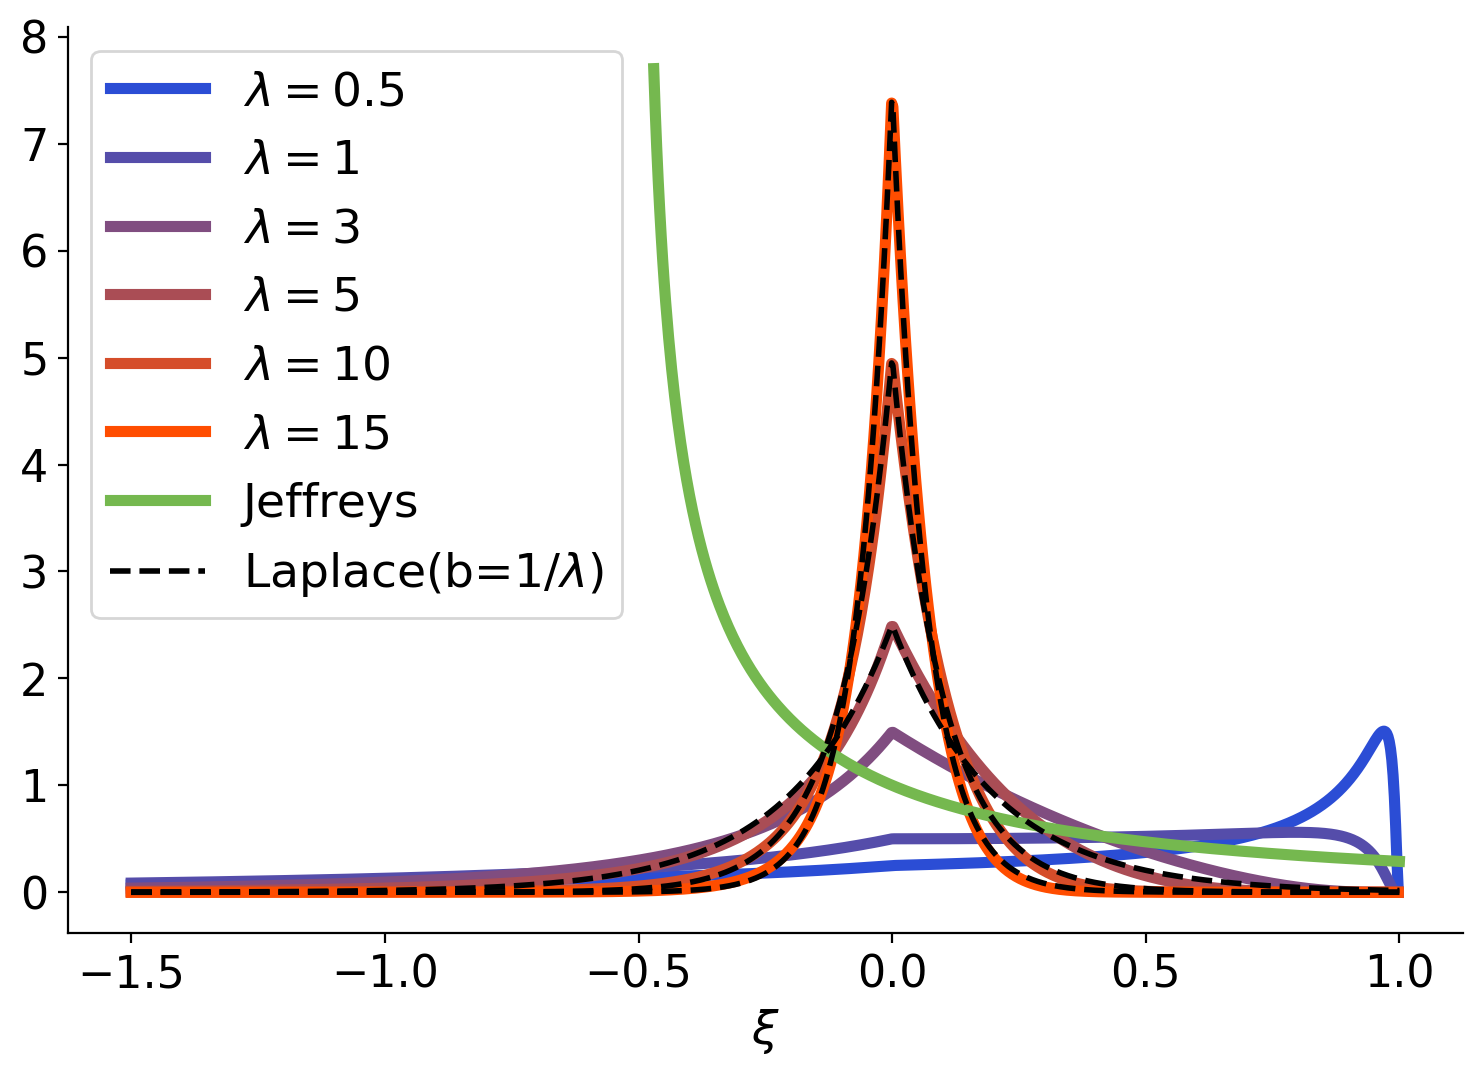

In [15]:
def pc_prior(xi, lam):
    return (lam/2) * ((1-xi/2)/(1-xi)**(3/2)) * np.exp(-lam * abs(xi)/np.sqrt(1-xi))

def laplace_prob(x, b):
    return np.exp(-abs(x)/b)/(2*b)

def jeffreys_prior(xi, sig = 1):
    return 1/(sig*sig*(1+xi)*np.sqrt(1+2*xi))

xi_range = np.linspace(-1.5, 1, 1000)

lam_range = [0.5, 1, 3, 5, 10, 15]


### Return level with varying $\lambda$:

#### $\lambda$ = 1:

In [16]:
print("\n Summary:")
display(az.summary(data=traces[0], stat_funcs=func_dict, 
                   var_names=["q"], hdi_prob = 0.95))
plt.show()


 Summary:


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mode
q[0],2138.955,69.413,2007.456,2279.358,1.044,0.739,4451.0,4903.0,1.0,2178.135
q[1],2235.080,71.912,2100.580,2383.081,1.095,0.776,4345.0,4990.0,1.0,2270.650
q[2],2323.194,74.978,2177.455,2471.550,1.159,0.821,4220.0,5035.0,1.0,2355.183
q[3],2405.225,78.324,2262.474,2569.513,1.229,0.871,4088.0,5113.0,1.0,2433.643
q[4],2482.467,81.791,2324.317,2645.381,1.304,0.924,3968.0,5044.0,1.0,2507.312
...,...,...,...,...,...,...,...,...,...,...
q[195],12281.051,4329.560,7395.020,19907.254,79.620,56.305,2679.0,3221.0,1.0,9798.674
q[196],12342.824,4390.368,7412.485,20077.732,80.695,57.065,2679.0,3192.0,1.0,9831.498
q[197],12404.815,4451.898,7426.856,20241.217,81.781,57.834,2680.0,3176.0,1.0,9864.291
q[198],12467.028,4514.159,7453.771,20418.126,82.880,58.611,2680.0,3186.0,1.0,9897.054


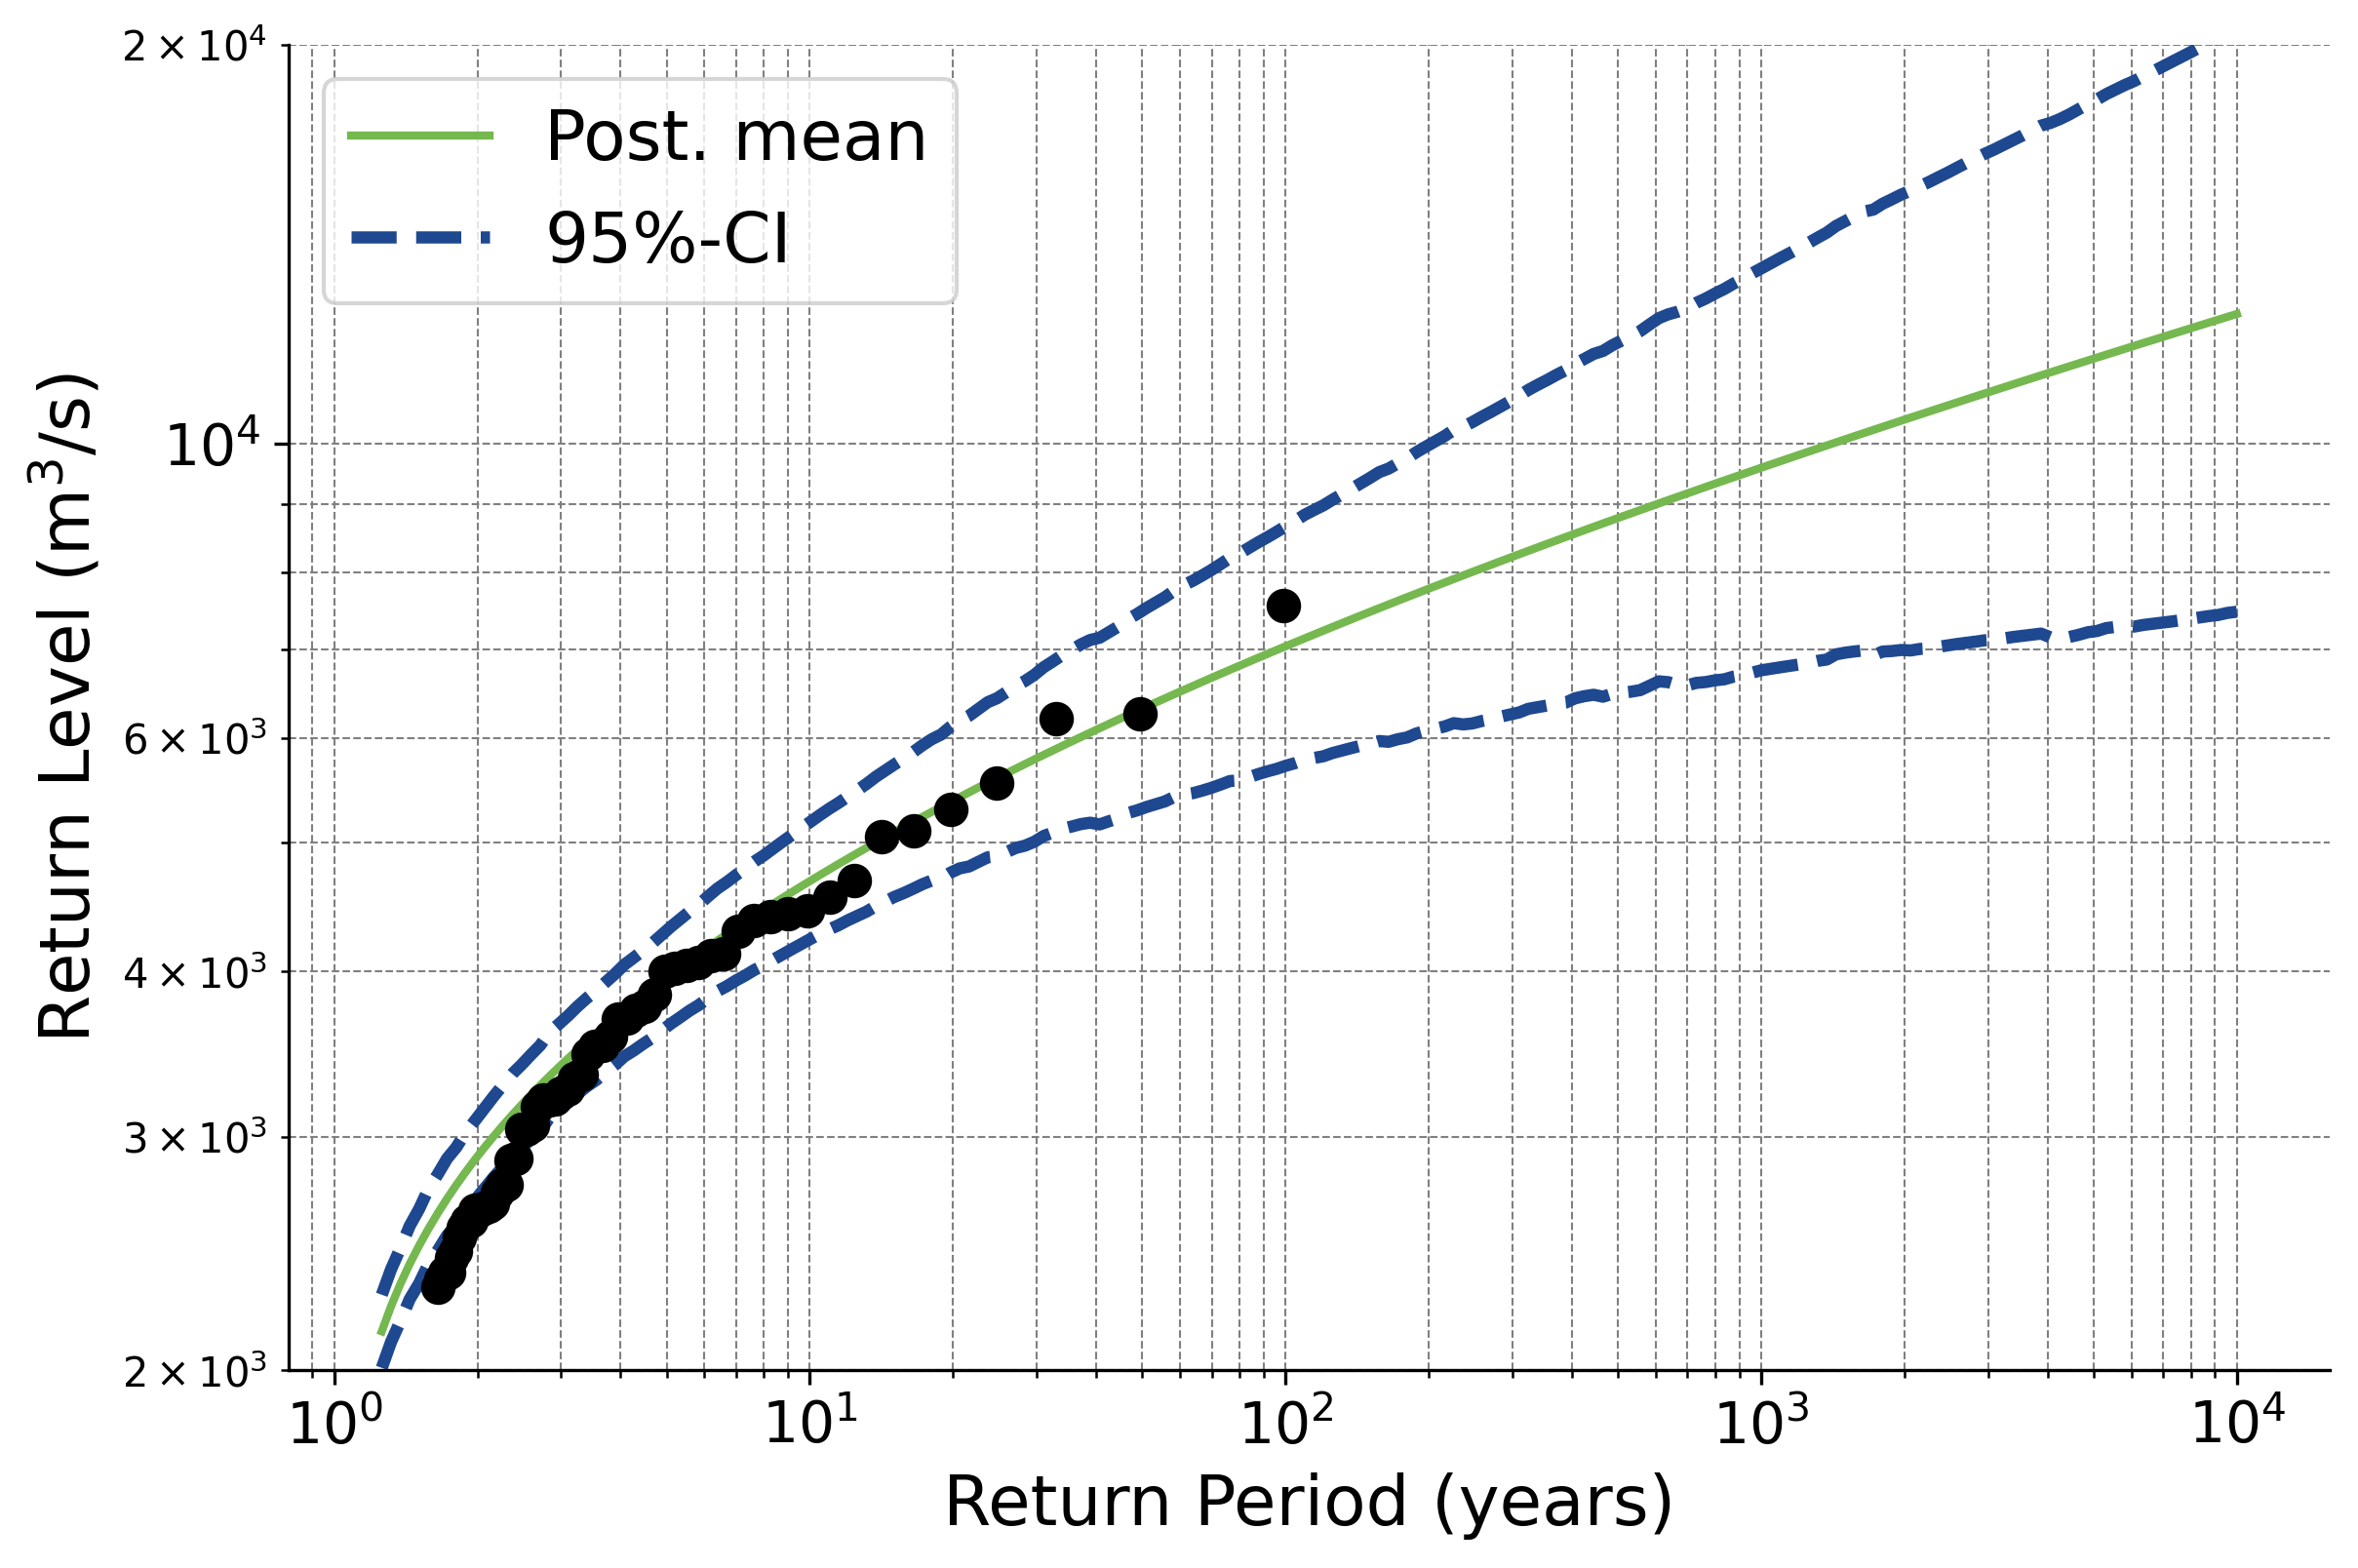

In [17]:
plot_return_level(traces[0], r_list)
plt.show()

In [36]:
param_mean = az.summary(data=traces[1], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["mu_m", "sig_m", "xi"])["mean"]
param_hdi1 = az.summary(data=traces[1], stat_funcs=func_dict, hdi_prob = 0.95,
                    var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
param_hdi2 = az.summary(data=traces[1], stat_funcs=func_dict, hdi_prob = 0.95,
                var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]

print("Méthode 1:")
print(get_return_level(r = 1000, trace = traces[1], param = param_hdi1))
print(get_return_level(r = 1000, trace = traces[1], param = param_mean))
print(get_return_level(r = 1000, trace = traces[1], param = param_hdi2))
print("")

print("Méthode 2:")
print(az.summary(data=traces[1], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["hdi_2.5%"][148])
print(az.summary(data=traces[1], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["mean"][148])
print(az.summary(data=traces[1], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["hdi_97.5%"][148])

Méthode 1:
6264.536435339203
9024.220998036144
13824.259120513052

Méthode 2:
7028.521
9164.64
11781.78


### Case $\xi = 0$:

In [19]:
print("\n Summary:")
display(az.summary(data=traces[3], stat_funcs=func_dict, 
                   var_names=["q"], hdi_prob = 0.95))
plt.show()


 Summary:


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mode
q[0],2141.067,69.443,2001.259,2274.901,1.104,0.783,3980.0,4851.0,1.0,2140.980
q[1],2237.278,70.873,2098.290,2376.891,1.138,0.807,3913.0,5104.0,1.0,2243.270
q[2],2325.369,72.763,2184.988,2469.446,1.183,0.838,3826.0,4966.0,1.0,2336.933
q[3],2407.286,74.981,2269.409,2561.639,1.234,0.875,3732.0,5190.0,1.0,2424.037
q[4],2484.338,77.437,2344.575,2647.200,1.290,0.914,3640.0,5140.0,1.0,2505.972
...,...,...,...,...,...,...,...,...,...,...
q[195],10850.913,656.315,9614.084,12172.585,12.865,9.098,2594.0,2842.0,1.0,11430.088
q[196],10892.339,659.373,9641.000,12210.913,12.925,9.140,2594.0,2842.0,1.0,11474.407
q[197],10933.765,662.431,9676.477,12257.604,12.985,9.183,2594.0,2842.0,1.0,11518.728
q[198],10975.190,665.491,9711.389,12304.294,13.045,9.225,2594.0,2842.0,1.0,11563.050


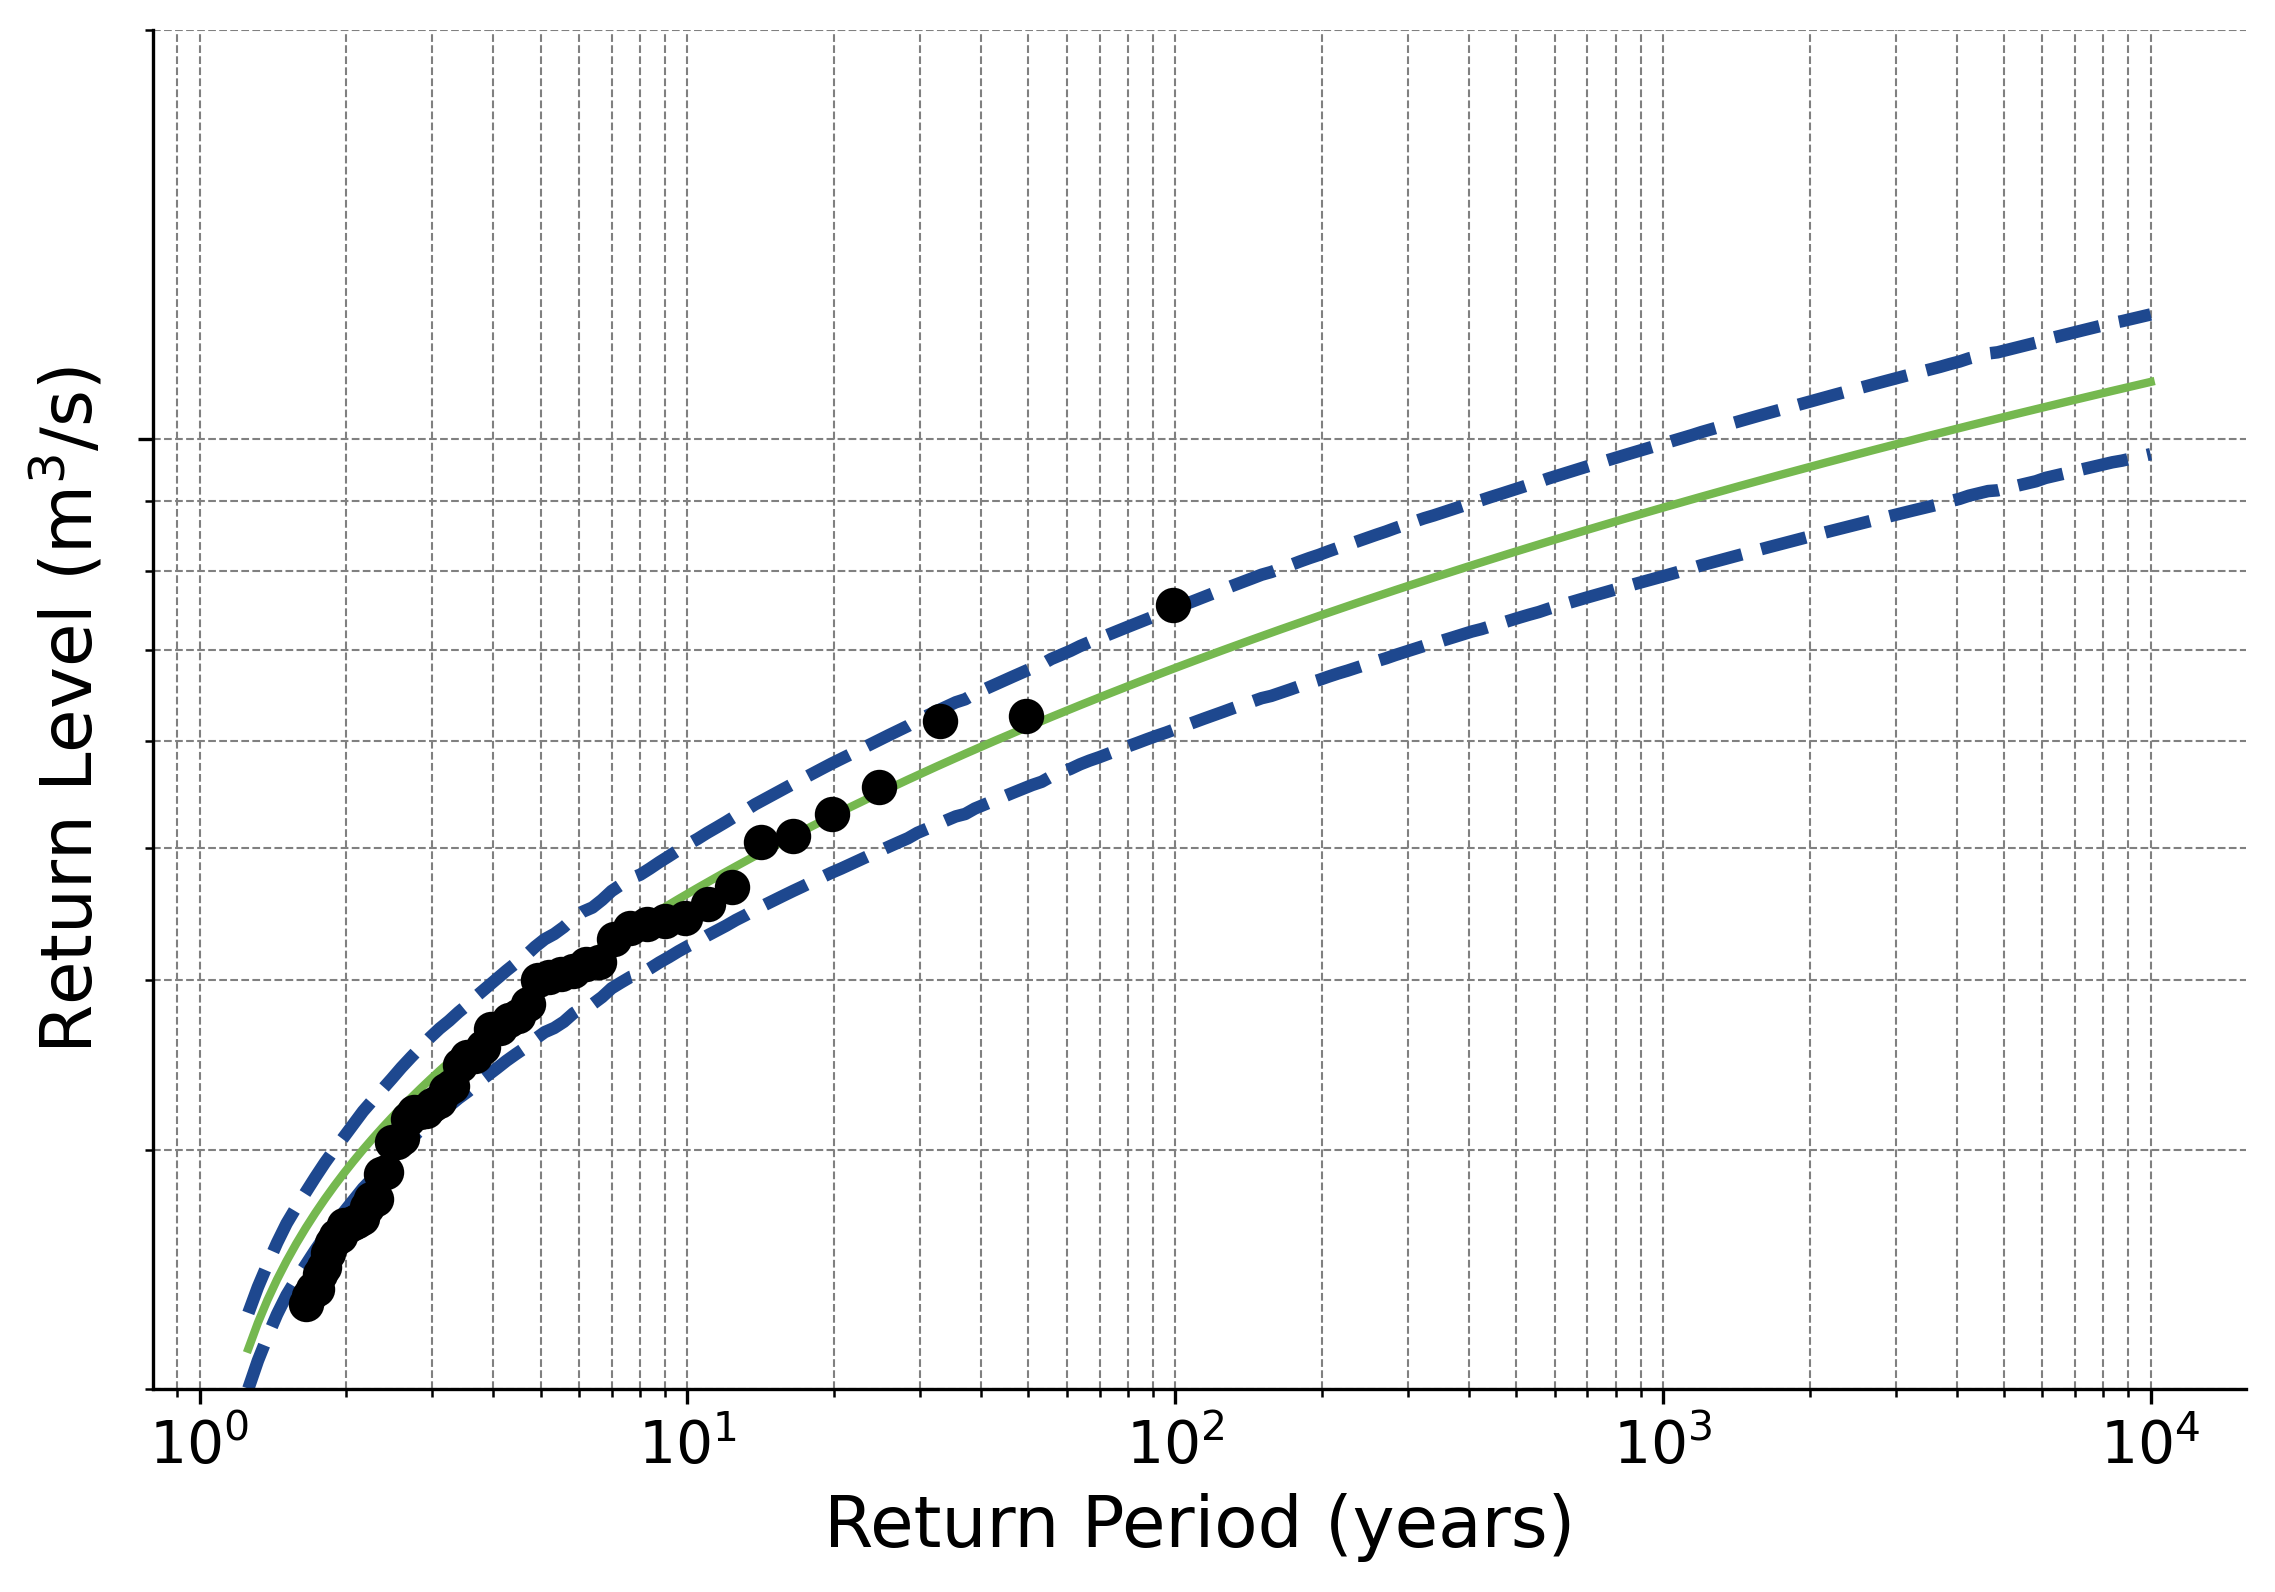

In [20]:
plot_return_level(traces[3], r_list, light_tail=True, ylabel = False)
plt.show()

In [21]:
param_mean = az.summary(data=traces[3], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["mu_m", "sig_m", "xi"])["mean"]
param_hdi1 = az.summary(data=traces[3], stat_funcs=func_dict, hdi_prob = 0.95,
                    var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
param_hdi2 = az.summary(data=traces[3], stat_funcs=func_dict, hdi_prob = 0.95,
                var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]

print("Méthode 1:")
print(get_return_level(r = 1000, trace = traces[3], param = param_hdi1, light_tail = True))
print(get_return_level(r = 1000, trace = traces[3], param = param_mean, light_tail = True))
print(get_return_level(r = 1000, trace = traces[3], param = param_hdi2, light_tail = True))
print("")

print("Méthode 2:")
print(az.summary(data=traces[3], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["hdi_2.5%"][-1])
print(az.summary(data=traces[3], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["mean"][-1])
print(az.summary(data=traces[3], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["q"])["hdi_97.5%"][-1])


Méthode 1:
7840.680602112636
8902.840392587112
9959.720214422754

Méthode 2:
9747.359
11016.616
12350.983


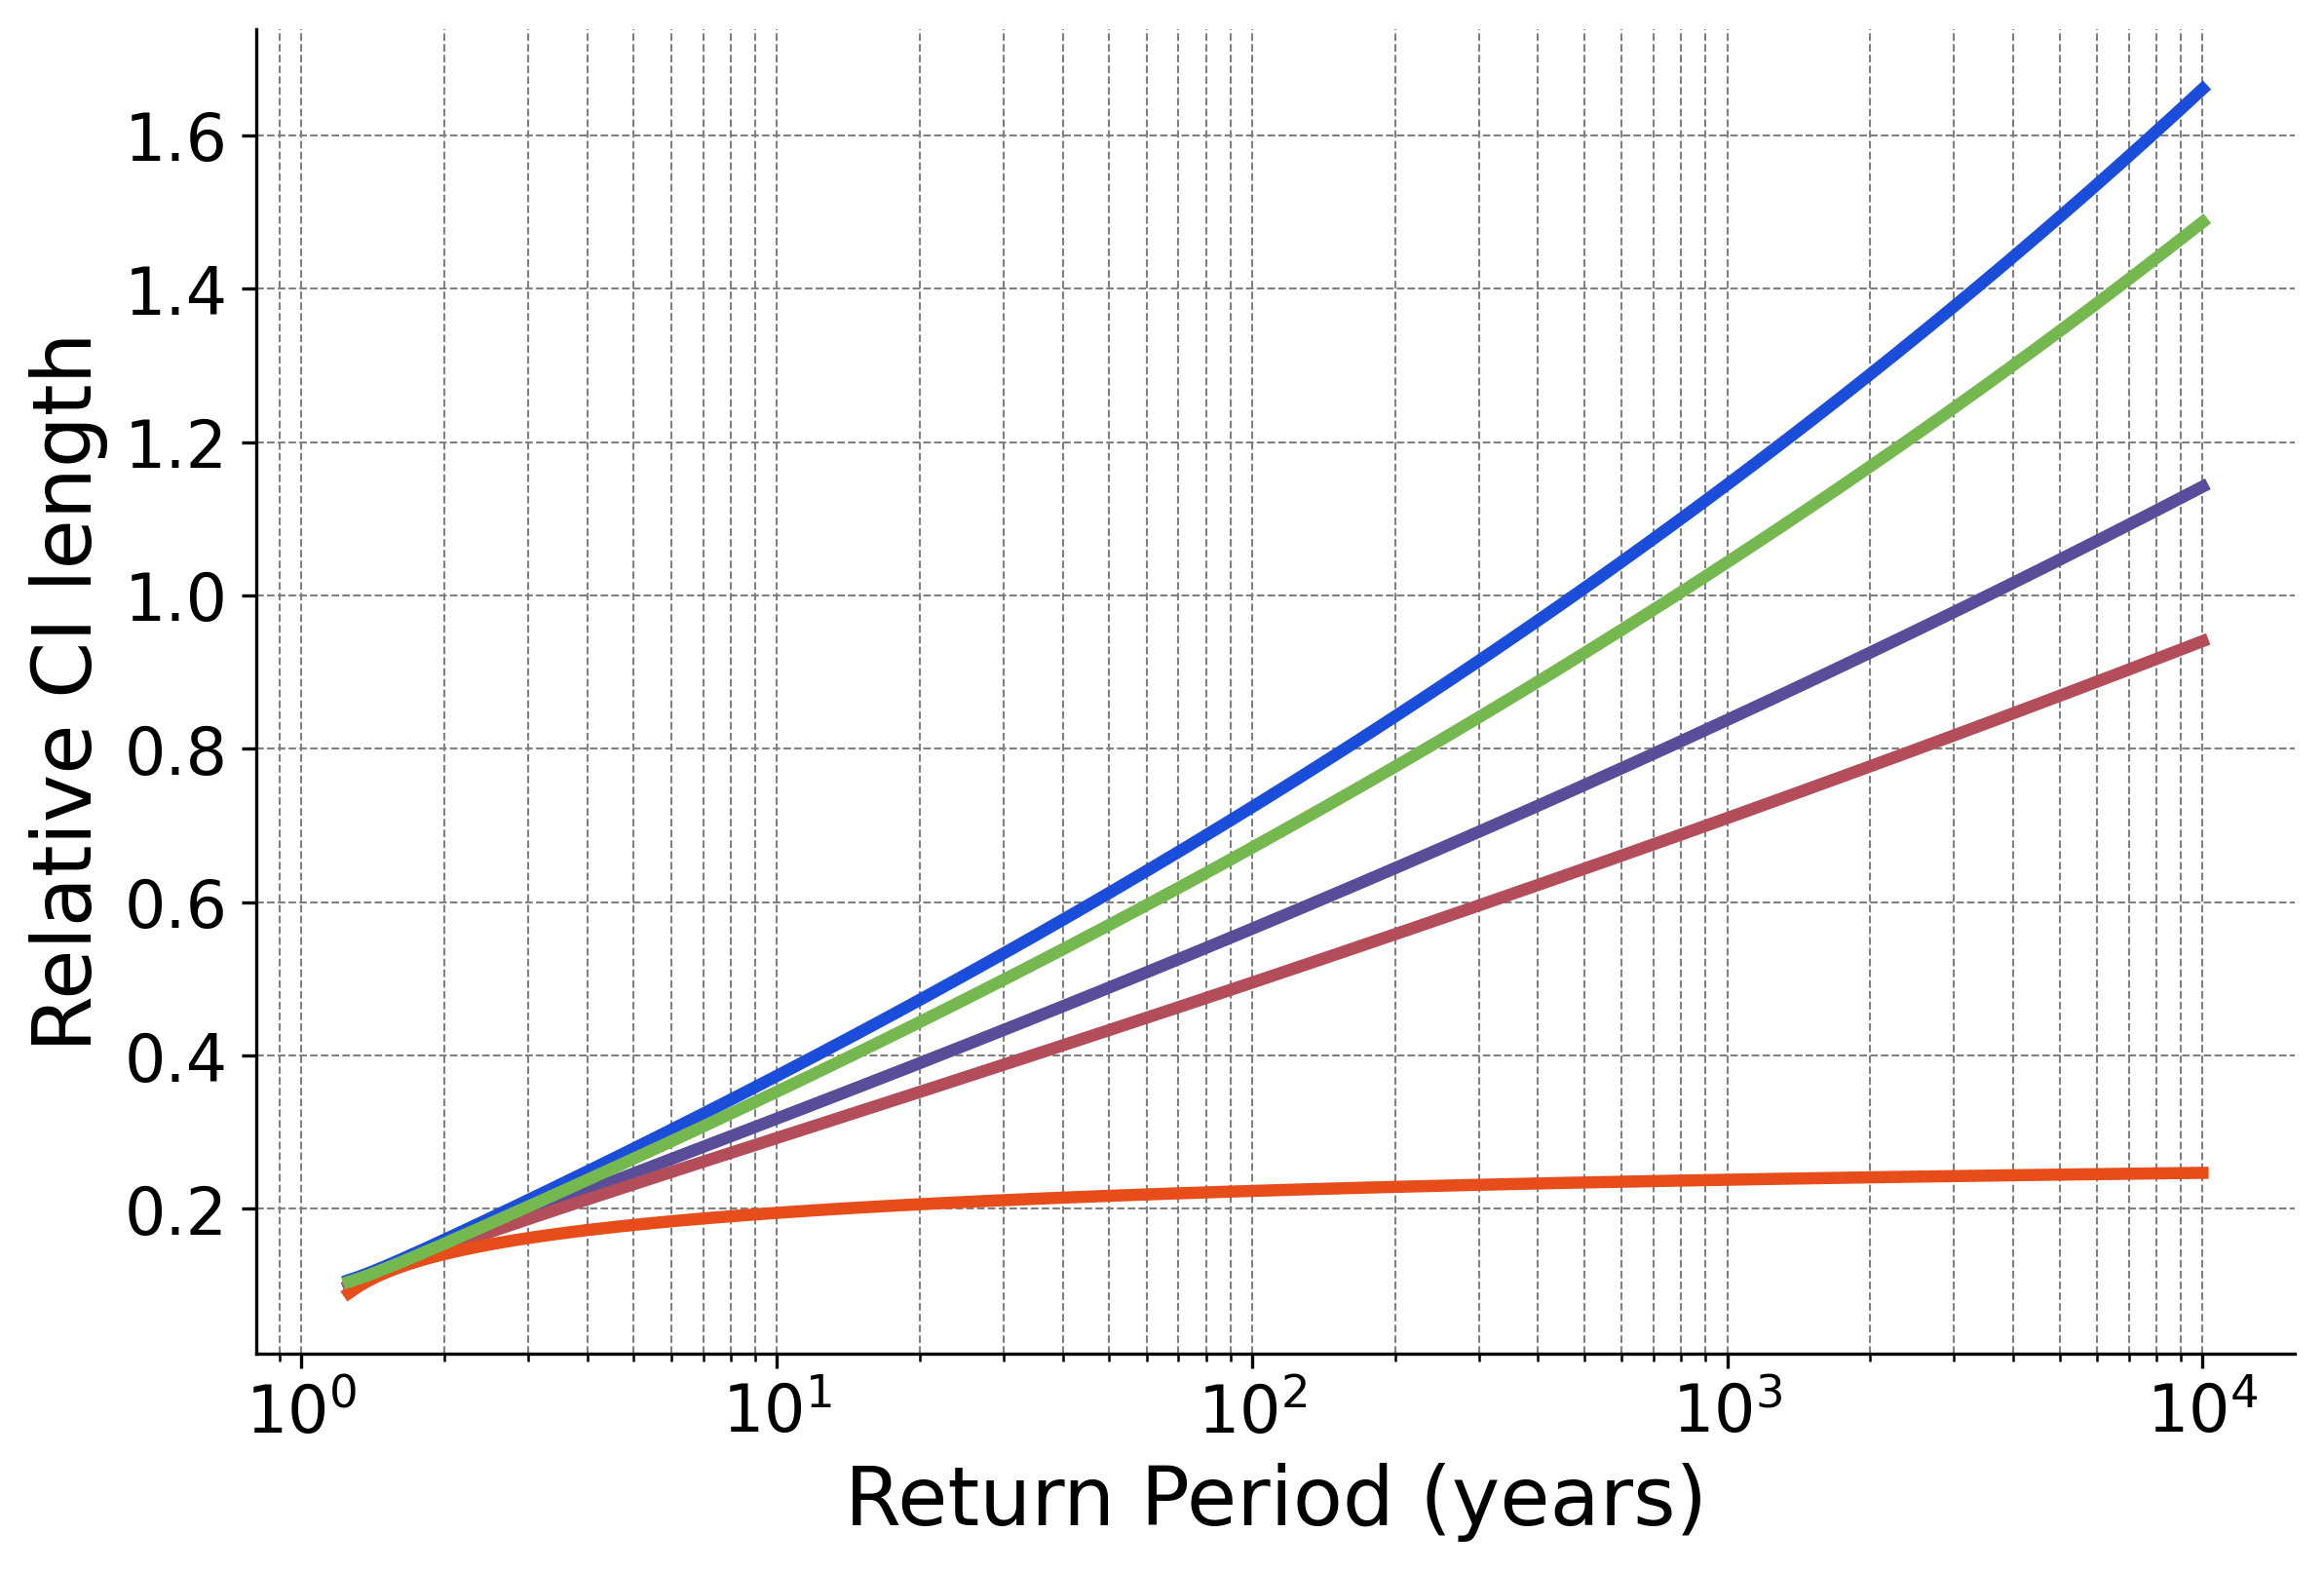

In [35]:

light_tail_list = [False, False, False, True, False]

r_list = np.logspace(0.1, 4, 200)

fig = plt.figure(figsize=(9,6), dpi=300)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

col_list = [(0.1, 0.3, 0.85), (0.35, 0.3, 0.6), (0.7, 0.3, 0.35), 
            (0.9, 0.3, 0.1), COLOR_LIST[1]]

for i, trace in enumerate(traces):
    
    param_mean = az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                            var_names=["mu_m", "sig_m", "xi"])["mean"]
    param_hdi1 = az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                            var_names=["mu_m", "sig_m", "xi"])["hdi_2.5%"]
    param_hdi2 = az.summary(data=trace, stat_funcs=func_dict, hdi_prob = 0.95,
                            var_names=["mu_m", "sig_m", "xi"])["hdi_97.5%"]
    
    levels_mean = [get_return_level(r, trace, param_mean, light_tail=light_tail_list[i]) for r in r_list]
    levels_hdi1 = [get_return_level(r, trace, param_hdi1, light_tail=light_tail_list[i]) for r in r_list]
    levels_hdi2 = [get_return_level(r, trace, param_hdi2, light_tail=light_tail_list[i]) for r in r_list]

    relative_length = [(i2-i1)/m for (m, i1, i2) in zip(levels_mean, levels_hdi1, levels_hdi2)]
    

    plt.plot(r_list, relative_length, "-", color=col_list[i], 
             linewidth = 3)
    plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)

    plt.xlabel("Return Period (years)",  fontsize = 20)
    plt.ylabel("Relative CI length",  fontsize = 20)
#     plt.legend(["$\lambda = 1$", 
#                 "$\lambda = 10$", 
#                 "$\lambda = 20$", 
#                 "$\lambda = \infty$ ($\\xi = 0$)",
#                 "Jeffreys"], fontsize = 20)

plt.show()

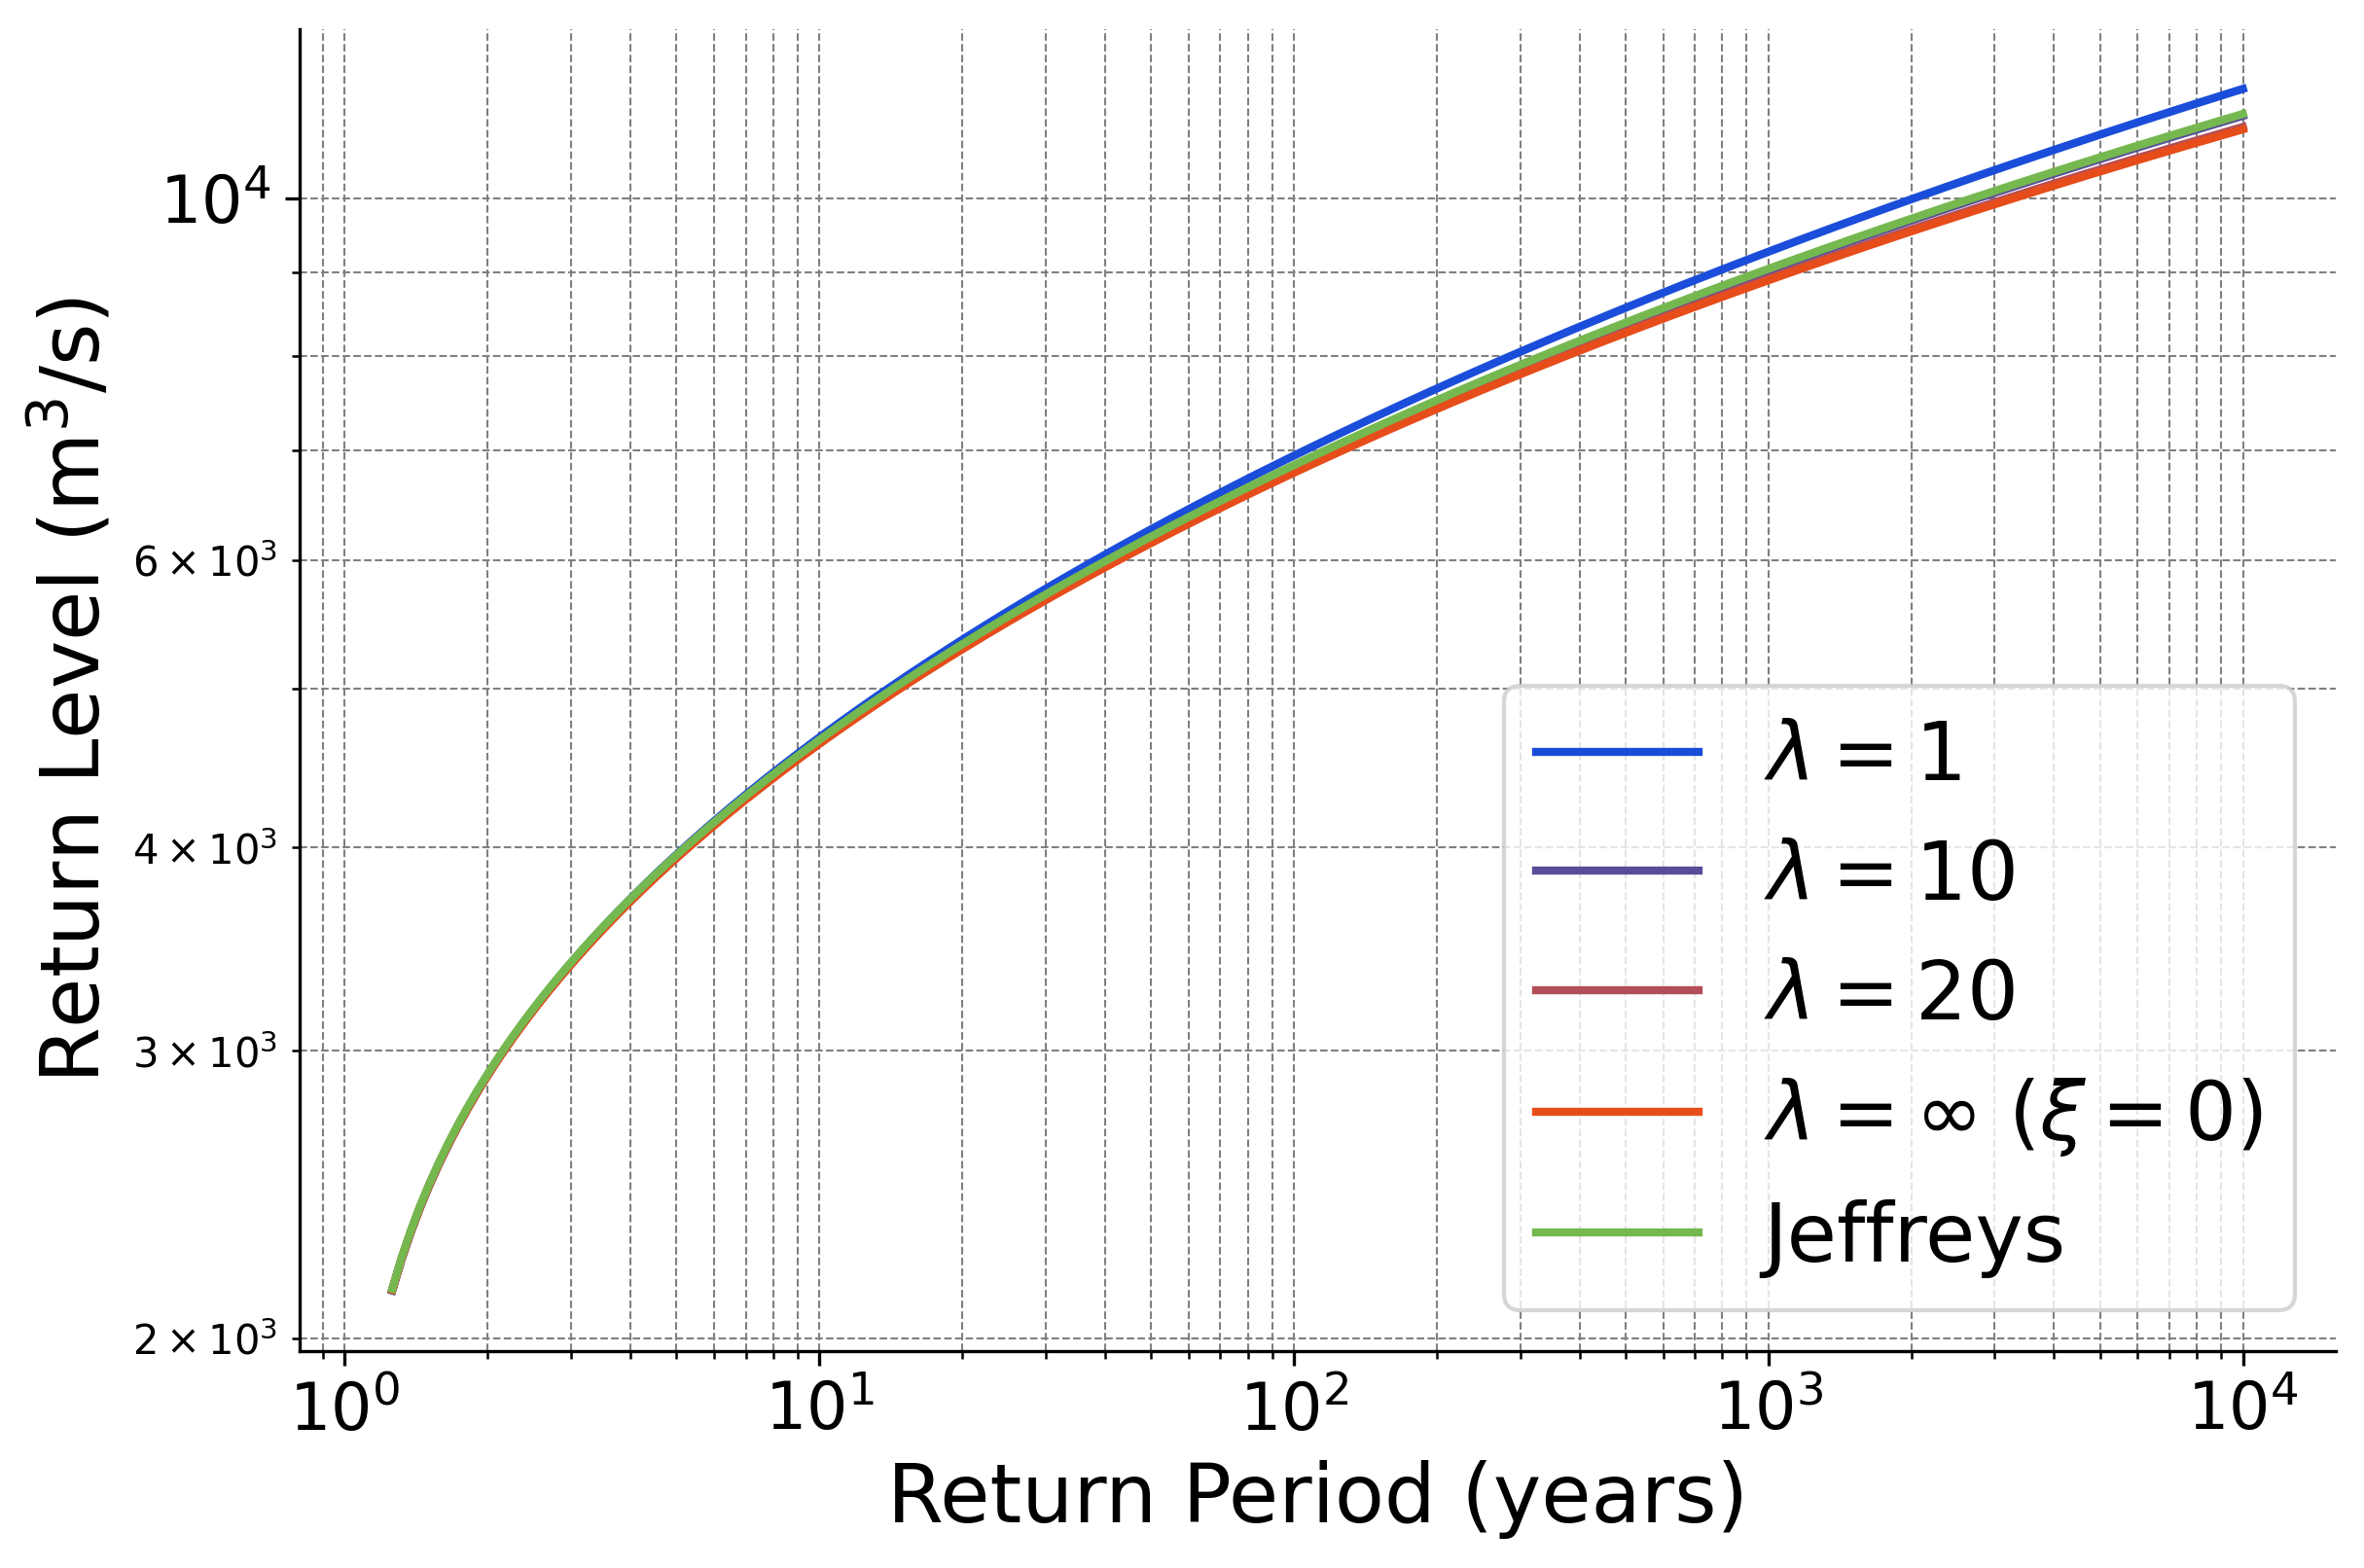

In [34]:

light_tail_list = [False, False, False, True]

r_list = np.logspace(0.1, 4, 200)

fig = plt.figure(figsize=(9,6), dpi=300)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# ax.set_ylim(0, 0.1)


col_list = [(0.1, 0.3, 0.85), (0.35, 0.3, 0.6), (0.7, 0.3, 0.35), 
            (0.9, 0.3, 0.1), COLOR_LIST[1]]

param_mean_jeffreys = az.summary(data=traces[-1], stat_funcs=func_dict, hdi_prob = 0.95,
                        var_names=["mu_m", "sig_m", "xi"])["mean"]
levels_mean_jeffreys = [get_return_level(r, traces[-1], param_mean_jeffreys, light_tail=False) for r in r_list]

for i, tail_bool in enumerate(light_tail_list):
    
    param_mean = az.summary(data=traces[i], stat_funcs=func_dict, hdi_prob = 0.95,
                            var_names=["mu_m", "sig_m", "xi"])["mean"]
    
    levels_mean = [get_return_level(r, traces[i], param_mean, light_tail=tail_bool) for r in r_list]

#     relative_length = [abs(i2-i1)/i1 for (i1, i2) in zip(levels_mean, levels_mean_jeffreys)]

    plt.plot(r_list, levels_mean, "-", color=col_list[i], 
             linewidth = 2)

plt.plot(r_list, levels_mean_jeffreys, "-", color=col_list[-1], 
     linewidth = 2)
plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)

plt.xlabel("Return Period (years)",  fontsize = 20)
plt.ylabel("Return Level (m$^3$/s)",  fontsize = 20)
plt.legend(["$\lambda = 1$", 
            "$\lambda = 10$", 
            "$\lambda = 20$", 
            "$\lambda = \infty$ ($\\xi = 0$)",
            "Jeffreys"], fontsize = 20)

plt.show()

# Evolution de l'estimation de xi en fonction du seuil

In [24]:
# mcmc_configs = ["Config2", "Config7"]

# threshold_list = np.linspace(1500,4500,31, dtype=int)

# decluster = True

# xi_means = []
# xi_hdi1 = []
# xi_hdi2 = []

# for filename in mcmc_configs:
#     print("\nConfig file: ", filename)
#     mcmc_params = Params(mcmc_params_directory + filename + ".json")
    
#     xi_means.append([])
#     xi_hdi1.append([])
#     xi_hdi2.append([])
    
#     for u in threshold_list:

#         print("u = {}\r".format(u), end="")

#         observations_under_u, obs, time_under_u, time = extract_data_castor(threshold = u)
#         if decluster:
#             obs, time = decluster_data(obs, time)

#         # MCMC

#         traces = []
#         names = []
        
#         nb_dim = len(mcmc_params.priors)
#         priors = [mcmc_params.priors["p1"],
#                   mcmc_params.priors["p2"]]

#         if nb_dim == 3:
#             priors.append(mcmc_params.priors["p3"])

#             if mcmc_params.init_p1_by_u:
#                 init_val = n_obs if mcmc_params.orthogonal_param else threshold
#                 priors[2] = priors[2].replace("u", str(init_val))

#         MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
#                            obs=obs, u=u, m=n_years, quantiles=quantiles,
#                            orthogonal_param=mcmc_params.orthogonal_param)
#         if mcmc_params.update_m != "":
#             MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
#         trace = MCMC.run(verbose=False)

#         xi_means[-1].append(float(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["mean"]))
#         xi_hdi1[-1].append(float(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_3%"]))
#         xi_hdi2[-1].append(float(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_97%"]))
    

In [25]:
# fig = plt.figure(figsize=(18,12))
# ax = fig.add_subplot(111)
# ax.xaxis.set_tick_params(labelsize=14)
# ax.yaxis.set_tick_params(labelsize=14)

# labels = ["Jeffreys prior", "PC prior"]

# for i in range(len(xi_means)):  
#     low_err = [x-y for (x,y) in zip(xi_means[i], xi_hdi1[i])]
#     up_err = [y-x for (x,y) in zip(xi_means[i], xi_hdi2[i])]

#     plt.errorbar([t+10*i for t in threshold_list], xi_means[i], yerr = [low_err, up_err], fmt='-o', 
#                  color=COLOR_LIST[i], ms = 10, label = labels[i])

# plt.title("Posterior means with HPD 3%/97%", fontsize = 17)
# plt.legend()
# plt.xlabel("Threshold", fontsize = 17)
# plt.ylabel("$\\xi$", fontsize = 17)
# plt.show()

In [26]:
# mcmc_configs = ["Config7", "Config8", "Config9"]

# threshold_list = np.linspace(1800,2800,21, dtype=int)

# decluster = True

# xi_means = []
# xi_hdi1 = []
# xi_hdi2 = []

# for filename in mcmc_configs:
#     print("\nConfig file: ", filename)
#     mcmc_params = Params(mcmc_params_directory + filename + ".json")
    
#     xi_means.append([])
#     xi_hdi1.append([])
#     xi_hdi2.append([])
    
#     for u in threshold_list:

#         print("u = {}\r".format(u), end="")

#         observations_under_u, obs, time_under_u, time = extract_data_castor(threshold = u)
#         if decluster:
#             obs, time = decluster_data(obs, time)

#         # MCMC

#         traces = []
#         names = []

#         nb_dim = len(mcmc_params.priors)
#         priors = [mcmc_params.priors["p1"],
#                   mcmc_params.priors["p2"]]

#         if nb_dim == 3:
#             priors.append(mcmc_params.priors["p3"])

#             if mcmc_params.init_p1_by_u:
#                 init_val = n_obs if mcmc_params.orthogonal_param else threshold
#                 priors[2] = priors[2].replace("u", str(init_val))

#         MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
#                            obs=obs, u=u, m=n_years, quantiles=quantiles,
#                            orthogonal_param=mcmc_params.orthogonal_param)
#         if mcmc_params.update_m != "":
#             MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
#         trace = MCMC.run(verbose=False)

#         xi_means[-1].append(float(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["mean"]))
#         xi_hdi1[-1].append(float(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_3%"]))
#         xi_hdi2[-1].append(float(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_97%"]))
    

In [27]:
# fig = plt.figure(figsize=(18,12))
# ax = fig.add_subplot(111)
# ax.xaxis.set_tick_params(labelsize=14)
# ax.yaxis.set_tick_params(labelsize=14)

# labels = ["PC prior, Lambda = 10", "PC prior, Lambda = 1", "PC prior, Lambda = 100"]

# for i in range(len(xi_means)):  
#     low_err = [x-y for (x,y) in zip(xi_means[i], xi_hdi1[i])]
#     up_err = [y-x for (x,y) in zip(xi_means[i], xi_hdi2[i])]

#     plt.errorbar([t+5*i for t in threshold_list], xi_means[i], yerr = [low_err, up_err], fmt='-o', 
#                  color=COLOR_LIST[i], ms = 10, label = labels[i])

# plt.title("Posterior means with HPD 3%/97%", fontsize = 17)
# plt.legend()
# plt.xlabel("Threshold", fontsize = 17)
# plt.ylabel("$\\xi$", fontsize = 17)
# plt.show()